# 01: LightGBM hyperparam tuning

Connected to the MySQL database


c:\Users\Miguel\Desktop\Catolica Data Analytics\CPBS-TS-2\utils\database.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_data = pd.read_sql(sql_query, connection)


Connection closed


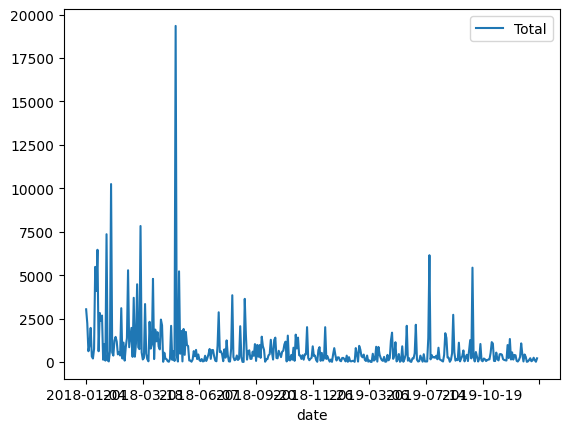

In [6]:
from utils.database import * 
from utils.utils import *
from utils.preprocessing import *
from utils.plotting import *
from utils.metrics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# make training set 
train_index = 550
STEPS = 28

agg_levels = {
    'level_1': None,
}

daily_data = fetch_target()
daily_data = pivot_data(daily_data, "ettdeb")
train_agg = aggregation(daily_data, 
                        agg_levels=agg_levels).T
train_agg.plot(kind = "line")
train_agg = train_agg["Total"]

In [7]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(train_agg) - test_size

train_series = train_agg[:split_time]
test_series = train_agg[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

## Baseline model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11696
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 180
[LightGBM] [Info] Start training from score 430.283935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

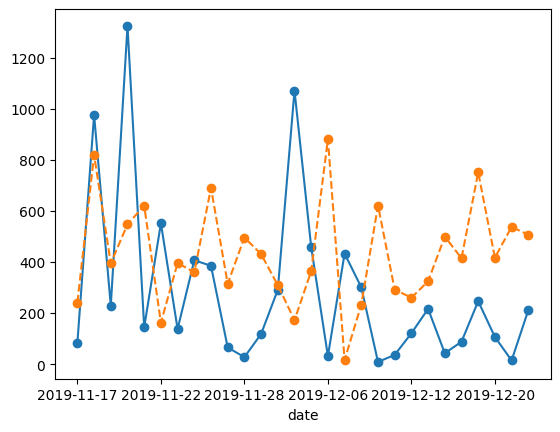

In [10]:
model = lgb.LGBMRegressor(first_metric_only = True)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)])

forecast = model.predict(test_x)
s1_naive = train_agg[-29:-1].to_numpy()
s7_naive = train_agg[-35:-7].to_numpy()
s30_naive = train_agg[-56:-28].to_numpy()
s365_naive = train_agg[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

train_agg[-test_size:].plot(marker = 'o')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()

## Number of trees

Number of trees is the number of estimators built (equal to the number of iterations in neural networks). The more trees or boosting iterations the model builds, the more complex the model becomes leading to better performance on the training data (altough I believe there is an option to prune early such as early stopping in case the gain isn't enough).

- During training, LightGBM builds decision trees. Each tree minimizes overall loss function
- Early stopping if enabled can mean the model stops building trees if the model performance doesn't improve
- Regularization, as controlling the number of trees can help prevent overfitting
- Trade-off between Bias and Variance, fewer trees lead to high bias, lots of trees lead to high variance
- Computational efficiency concerns

 10 --- MAE: -407.919 (138.726)
 50 --- MAE: -434.347 (139.993)
100 --- MAE: -461.147 (142.053)
500 --- MAE: -514.146 (140.847)
1000 --- MAE: -519.975 (142.849)


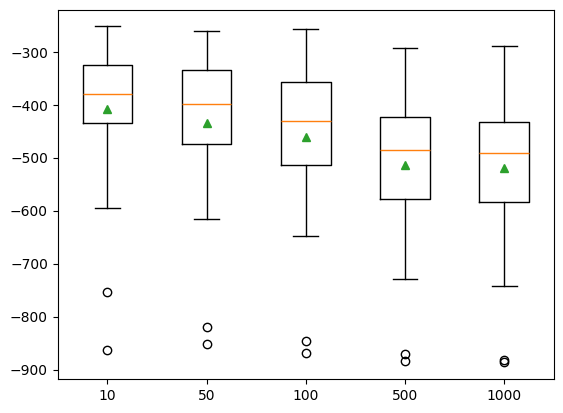

In [11]:
trees = [10, 50, 100, 500, 1000]

results = []
names = []
for i in trees:
    
    params = {
        'n_estimators': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## Tree Depth

Defines the maximum depth from the root node to the leaf nodes. A tree with depth 1 = root node, tree with depth 2 = 1 child leaf, etc.

- Model complexity: tree depth controls the complexity of the model, deeper tree overfits more. In particular, high depth captures more intrincate systems of the data, just like using deep neural networks.
- Trade-off bias variance, for the same reason. High depth -> high variance, low depth -> high bias
- Preventing overfitting
- Interpretability, shallower trees are often easier to visualize and interpret if so
- Computational efficiency concern

  1 --- MAE: -429.702 (134.953)
  2 --- MAE: -455.404 (140.963)
  3 --- MAE: -449.474 (141.980)
  4 --- MAE: -455.367 (140.312)
  5 --- MAE: -455.754 (142.959)
  6 --- MAE: -462.217 (142.242)
  7 --- MAE: -461.147 (142.053)
  8 --- MAE: -461.147 (142.053)
  9 --- MAE: -461.147 (142.053)
 10 --- MAE: -461.147 (142.053)


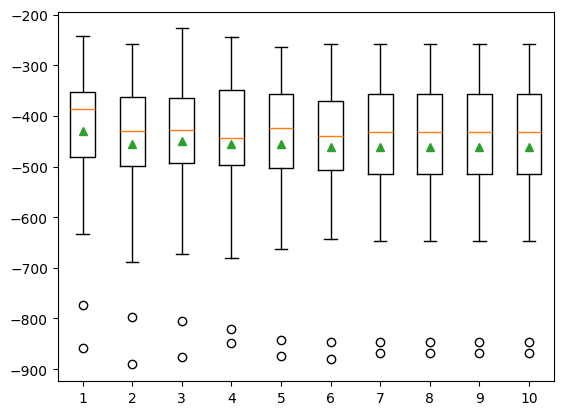

In [12]:
results = []
names = []
for i in range(1, 11):
    
    params = {
        'max_depth': i,
        'num_leaves': 2**i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## Learning rate

Learning rate determins the rate of change of internal parameters across batches. The main effects are 1: convergence rate 2: convergence aka local minima issue. While a higher training rate may lead to faster convergence, it can create stability issues, where the loss isn't close to a monotonic series.

- Impact on convergence
- Balancing speend and accuracy between training speed and accuracy

0.000 --- MAE: -396.063 (135.814)
0.001 --- MAE: -398.921 (136.801)
0.010 --- MAE: -410.746 (138.381)
0.100 --- MAE: -461.147 (142.053)
1.000 --- MAE: -656.736 (152.821)


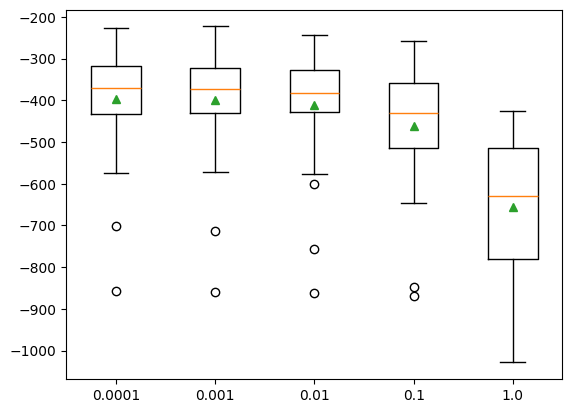

In [13]:
rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

results = []
names = []
for i in rates:
    
    params = {
        'learning_rate': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%.3f --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## Final model  

gbdt 1 --- MAE: -448.081 (138.681)
gbdt 2 --- MAE: -476.075 (139.041)
gbdt 3 --- MAE: -469.084 (140.392)
gbdt 4 --- MAE: -479.587 (142.283)
gbdt 5 --- MAE: -483.955 (141.084)
gbdt 6 --- MAE: -485.334 (139.606)
gbdt 7 --- MAE: -485.599 (139.556)
gbdt 8 --- MAE: -485.599 (139.556)
gbdt 9 --- MAE: -485.599 (139.556)
gbdt 10 --- MAE: -485.599 (139.556)
dart 1 --- MAE: -406.580 (140.006)
dart 2 --- MAE: -415.321 (140.305)
dart 3 --- MAE: -419.236 (139.773)
dart 4 --- MAE: -426.850 (141.419)
dart 5 --- MAE: -429.161 (140.688)
dart 6 --- MAE: -428.352 (140.499)
dart 7 --- MAE: -428.496 (140.239)
dart 8 --- MAE: -428.496 (140.239)
dart 9 --- MAE: -428.496 (140.239)
dart 10 --- MAE: -428.496 (140.239)
goss 1 --- MAE: -448.710 (123.138)
goss 2 --- MAE: -447.507 (124.305)
goss 3 --- MAE: -446.747 (123.502)
goss 4 --- MAE: -447.677 (121.736)
goss 5 --- MAE: -445.725 (122.515)
goss 6 --- MAE: -443.943 (123.213)
goss 7 --- MAE: -444.592 (122.600)
goss 8 --- MAE: -444.592 (122.600)
goss 9 --- MAE: -4

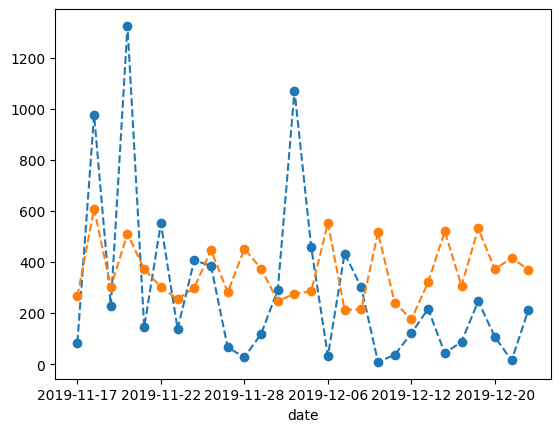

In [26]:
types = ['gbdt', 'dart', 'goss']

results = []
for i in types:
    
    for j in range(1, 11):
    
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.01,
            'max_depth': j,
            'num_leaves': 2**j,
            'boosting_type': i,
        }

        cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
        scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
        results.append(scores)

        print('%s %d --- MAE: %.3f (%.3f)' % (i, j, np.mean(scores), np.std(scores)))

train_agg[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(train_agg[-test_size:].index, forecast, marker = 'o', linestyle = '--')
plt.show()